In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import pandas as pd
import calendar
import plotly.graph_objects as go
import itertools
import math
import networkx as nx
from community import community_louvain

In [2]:
#import csv file separater by ;
data = pd.read_csv('mumps.csv', sep=';')

def week2month(hep):
    hep['LastDayWeek'] = pd.to_datetime((hep['week']-1).astype(str) + "6", format="%Y%U%w")
    hep['MonthMax'] = pd.DatetimeIndex(hep['LastDayWeek']).month
    hep['Year'] = pd.DatetimeIndex(hep['LastDayWeek']).year
    hep['MonthName'] = [calendar.month_name[i] for i in hep.MonthMax]
    return hep


data = week2month(data)

# SIR model

In [3]:
def plotdata_ex(t, s, i, e, a):
    # plot the data
    fig = plt.figure(figsize=(12,6))
    ax = [fig.add_subplot(221, axisbelow=True), 
          fig.add_subplot(223),
          fig.add_subplot(122)]

    ax[0].plot(t, s, lw=3, label='Fraction Susceptible')
    ax[0].plot(t, i, lw=3, label='Fraction Infective')
    ax[0].plot(t, r, lw=3, label='Recovered')
    ax[0].plot(t, a, lw=3, label='Asymptomatic')
    ax[0].set_title('Susceptible and Recovered Populations')
    ax[0].set_xlabel('Time /days')
    ax[0].set_ylabel('Fraction')

    ax[1].plot(t, i, lw=3, label='Infective')
    ax[1].set_title('Infectious Population')
    if e is not None: ax[1].plot(t, e, lw=3, label='Exposed')
    ax[1].set_ylim(0, 0.3)
    ax[1].set_xlabel('Time /days')
    ax[1].set_ylabel('Fraction')

    ax[2].plot(s, i, lw=3, label='s, i trajectory')
    ax[2].plot([1/R0, 1/R0], [0, 1], '--', lw=3, label='di/dt = 0')
    ax[2].plot(s[0], i[0], '.', ms=20, label='Initial Condition')
    ax[2].plot(s[-1], i[-1], '.', ms=20, label='Final Condition')
    ax[2].set_title('State Trajectory')
    ax[2].set_aspect('equal')
    ax[2].set_ylim(0, 1.05)
    ax[2].set_xlim(0, 1.05)
    ax[2].set_xlabel('Susceptible')
    ax[2].set_ylabel('Infectious')

    for a in ax: 
        a.grid(True)
        a.legend()

    plt.tight_layout()
    


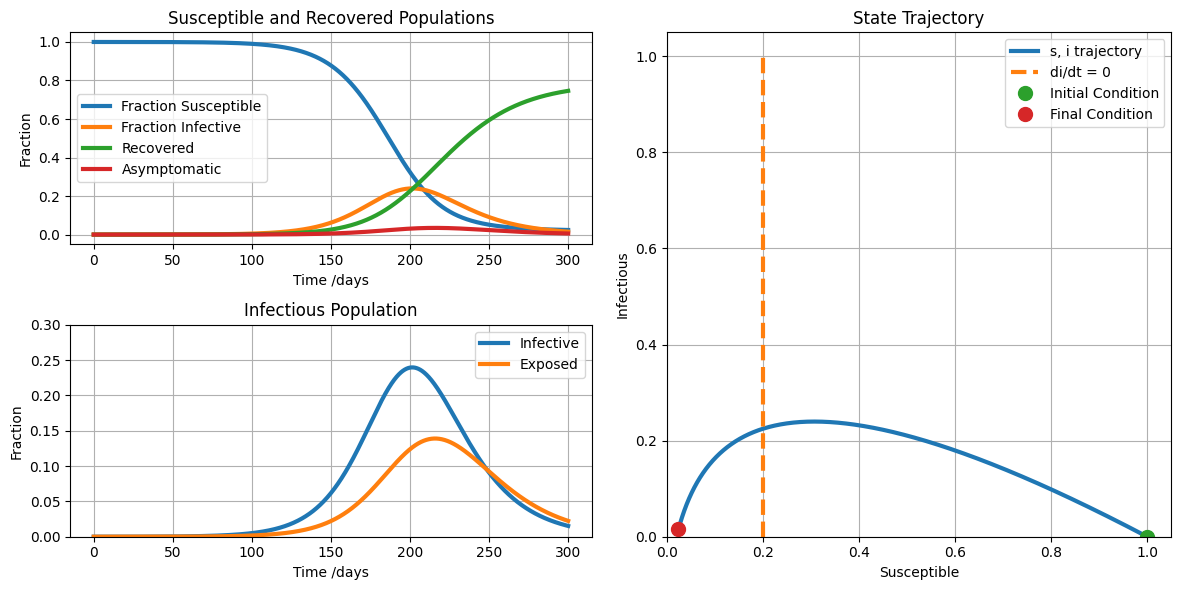

In [4]:
# parameter values
R0 = 5
t_incubation = 21
t_infective = 1/0.05882
#Proportion of those asymptomatic	
p = 0.2
u = 0

# initial number of infected and recovered individuals
e_initial = 1/20000
i_initial = 0.00
r_initial = 0.00
a_initial = 0.00
s_initial = 1 - e_initial - i_initial - r_initial -a_initial

alpha = 1/t_incubation
gamma = 1/t_infective
beta = R0*gamma

# SEIR model differential equations.
def deriv(x, t, alpha, beta, gamma, p):
    s, e, i, r ,a = x
    dsdt = -(1-u)*beta * s * i
    dedt =  (1-u)*beta * s * i - alpha * e
    dadt = alpha * e *p - gamma * a
    didt = alpha * e *(1-p) - gamma * i
    drdt =  gamma * i
    return [dsdt, dedt, didt, drdt, dadt]

t = np.linspace(0, 300, 2000)
x_initial = s_initial, e_initial, i_initial, r_initial, a_initial
soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma, p))
s, e, i, r, a = soln.T

plotdata_ex(t, s, e, i, a)

# Wuhan model (with asymptomatic)

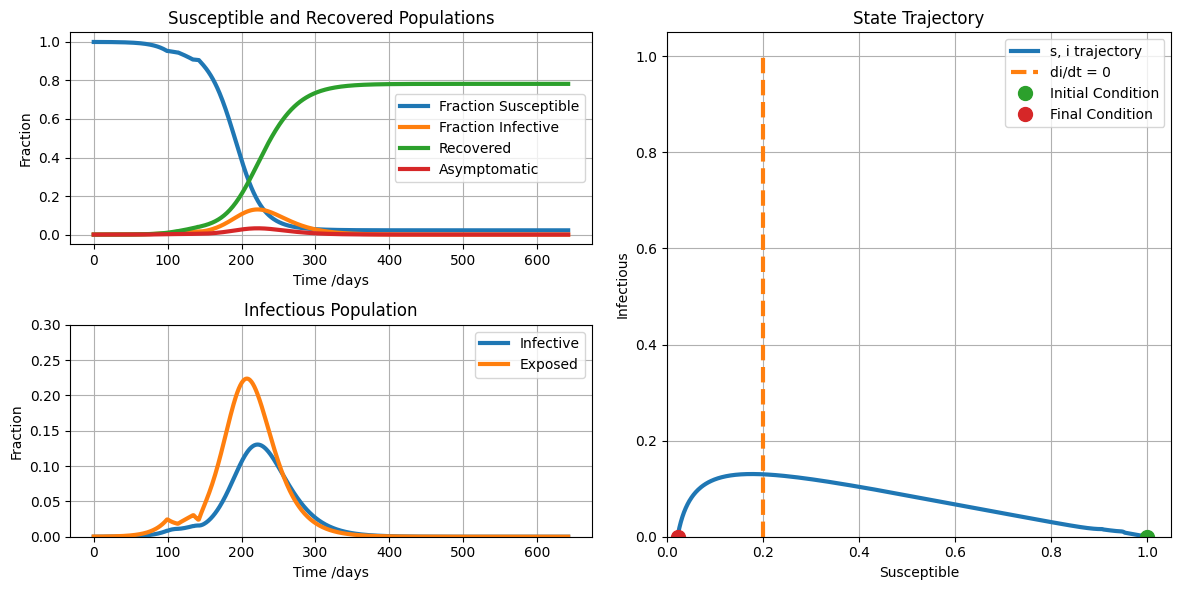

In [5]:
def plotdata(t, list_s, list_i, list_e, list_r):
    # plot the data
    fig = plt.figure(figsize=(12,6))
    ax = [fig.add_subplot(221, axisbelow=True), 
          fig.add_subplot(223),
          fig.add_subplot(122)]

    ax[0].plot(t, list_s, lw=3, label='Fraction Susceptible')
    ax[0].plot(t, list_i, lw=3, label='Fraction Infective')
    ax[0].plot(t, list_r, lw=3, label='Recovered')
    ax[0].plot(t, list_a, lw=3, label='Asymptomatic')
    ax[0].set_title('Susceptible and Recovered Populations')
    ax[0].set_xlabel('Time /days')
    ax[0].set_ylabel('Fraction')

    ax[1].plot(t, list_i, lw=3, label='Infective')
    ax[1].set_title('Infectious Population')
    if list_e is not None: ax[1].plot(t, list_e, lw=3, label='Exposed')
    ax[1].set_ylim(0, 0.3)
    ax[1].set_xlabel('Time /days')
    ax[1].set_ylabel('Fraction')

    ax[2].plot(list_s, list_i, lw=3, label='s, i trajectory')
    ax[2].plot([1/R0, 1/R0], [0, 1], '--', lw=3, label='di/dt = 0')
    ax[2].plot(list_s[0], list_i[0], '.', ms=20, label='Initial Condition')
    ax[2].plot(list_s[-1], list_i[-1], '.', ms=20, label='Final Condition')
    ax[2].set_title('State Trajectory')
    ax[2].set_aspect('equal')
    ax[2].set_ylim(0, 1.05)
    ax[2].set_xlim(0, 1.05)
    ax[2].set_xlabel('Susceptible')
    ax[2].set_ylabel('Infectious')

    for a in ax: 
        a.grid(True)
        a.legend()

    plt.tight_layout()


list_e = []
list_i = []
list_r = []
list_s = []
list_a = []
# parameter values

R0 = 5
t_incubation = 21
#Proportion of those asymptomatic	
p = 0.2

# initial number of infected and recovered individuals
e_initial = 10/40000
i_initial = 0.00
r_initial = 0.00
a_initial = 0.00
s_initial = 1 - e_initial - i_initial - r_initial - a_initial

alpha = 1/t_incubation
gamma = 0.05882
beta = R0*gamma

# SEIR model differential equations.
def deriv(x, t, alpha, beta, gamma, p):
    s, e, i, r ,a = x
    dsdt = -(1-u)*beta * s * i
    dedt =  (1-u)*beta * s * i - alpha * e
    dadt = alpha * e *p - gamma * a
    didt = alpha * e * (1-p) - gamma * i
    drdt =  gamma * i
    return [dsdt, dedt, didt, drdt, dadt]



# premier quadri
t = np.linspace(0, 100, 100)
u = 0
x_initial = s_initial, e_initial, i_initial, a_initial, r_initial
soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma, p))
s, e, i, r, a = soln.T
list_s.append(s.tolist())
list_e.append(e.tolist())
list_i.append(i.tolist())
list_a.append(a.tolist())
list_r.append(r.tolist())

#blocus
t = np.linspace(0, 14, 14)
u=0.8
x_initial = s[-1], e[-1], i[-1], r[-1], a[-1]
soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma, p))
s, e, i, r, a = soln.T
list_s.append(s.tolist())
list_e.append(e.tolist())
list_i.append(i.tolist())
list_a.append(a.tolist())
list_r.append(r.tolist())

#session d'examen
t = np.linspace(0, 21, 21)
u=0.5
x_initial = s[-1], e[-1], i[-1], r[-1], a[-1]
soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma, p))
s, e, i, r, a = soln.T
list_s.append(s.tolist())
list_e.append(e.tolist())
list_i.append(i.tolist())
list_a.append(a.tolist())
list_r.append(r.tolist())

#semaine blanche
t = np.linspace(0, 7, 7)
u=0.9
x_initial = s[-1], e[-1], i[-1], r[-1], a[-1]
soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma, p))
s, e, i, r, a = soln.T
list_s.append(s.tolist())
list_e.append(e.tolist())
list_i.append(i.tolist())
list_a.append(a.tolist())
list_r.append(r.tolist())


#deuxieme quadri
t = np.linspace(0, 500, 500)
u=0
x_initial = s[-1], e[-1], i[-1], r[-1], a[-1]
soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma, p))
s, e, i, r, a = soln.T
list_s.append(s.tolist())
list_e.append(e.tolist())
list_i.append(i.tolist())
list_a.append(a.tolist())
list_r.append(r.tolist())

list_s = list(itertools.chain(*list_s))
list_e = list(itertools.chain(*list_e))
list_i = list(itertools.chain(*list_i))
list_r = list(itertools.chain(*list_r))
list_a = list(itertools.chain(*list_a))


t = np.linspace(0, len(list_r), len(list_r))
plotdata(t, list_s, list_i, list_e, list_r)




# Networks

## Let's see a normal SEIR model

In [6]:

def plotdata_SEIR(t, s, e, i ,r):
    # plot the data
    fig = plt.figure(figsize=(12,6))
    ax = [fig.add_subplot(221, axisbelow=True), 
          fig.add_subplot(223),
          fig.add_subplot(122)]

    ax[0].plot(t, s, lw=3, label='Fraction Susceptible', color='tab:blue')
    #color = 'tab:blue'
    ax[0].plot(t, i, lw=3, label='Fraction Infective', color = 'tab:green')
    ax[0].plot(t, r, lw=3, label='Recovered', color = 'tab:red')
    ax[0].plot(t, e, lw=3, label='Exposed', color = 'tab:orange')
    ax[0].set_title('Susceptible and Recovered Populations')
    ax[0].set_xlabel('Time /days')
    ax[0].set_ylabel('Fraction')

    ax[1].plot(t, i, lw=3, label='Infective')
    ax[1].set_title('Infectious Population')
    if e is not None: ax[1].plot(t, e, lw=3, label='Exposed')
    ax[1].set_ylim(0, 0.3)
    ax[1].set_xlabel('Time /days')
    ax[1].set_ylabel('Fraction')

    ax[2].plot(s, i, lw=3, label='s, i trajectory')
    ax[2].plot([1/R0, 1/R0], [0, 1], '--', lw=3, label='di/dt = 0')
    ax[2].plot(s[0], i[0], '.', ms=20, label='Initial Condition')
    ax[2].plot(s[-1], i[-1], '.', ms=20, label='Final Condition')
    ax[2].set_title('State Trajectory')
    ax[2].set_aspect('equal')
    ax[2].set_ylim(0, 1.05)
    ax[2].set_xlim(0, 1.05)
    ax[2].set_xlabel('Susceptible')
    ax[2].set_ylabel('Infectious')

    for a in ax: 
        a.grid(True)
        a.legend()

    plt.tight_layout()

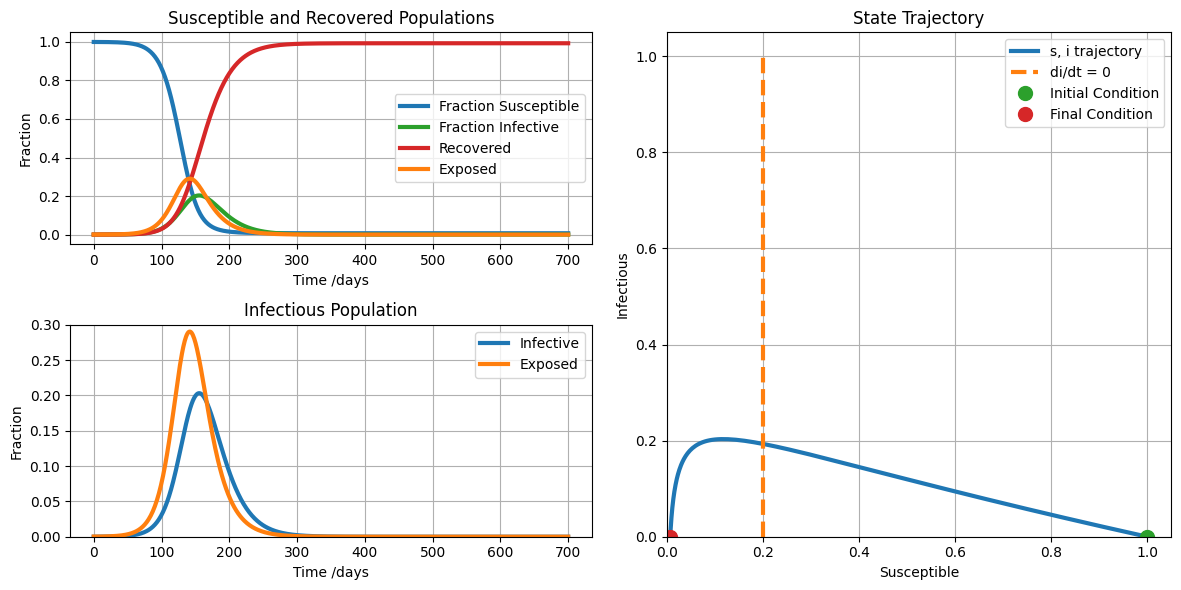

In [7]:
# parameter values
R0 = 5
t_incubation = 21

# initial number of infected and recovered individuals
e_initial = 10/40000
i_initial = 0.00
r_initial = 0.00
s_initial = 1 - e_initial - i_initial - r_initial

alpha = 1/t_incubation
gamma = 0.05882
beta = R0*gamma

# SEIR model differential equations.
def deriv(x, t, alpha, beta, gamma):
    s, e, i, r = x
    dsdt = -beta * s * i
    dedt =  beta * s * i - alpha * e
    didt = alpha * e - gamma * i
    drdt =  gamma * i
    return [dsdt, dedt, didt, drdt]

t = np.linspace(0, 700, 700)
x_initial = s_initial, e_initial, i_initial, r_initial
soln = odeint(deriv, x_initial, t, args=(alpha, beta, gamma))
s, e, i, r = soln.T

plotdata_SEIR(t, s, e, i, r)

## Let's build it on a network

generating graph G with 100000 nodes
doing Gillespie simulation
done with simulation, now plotting


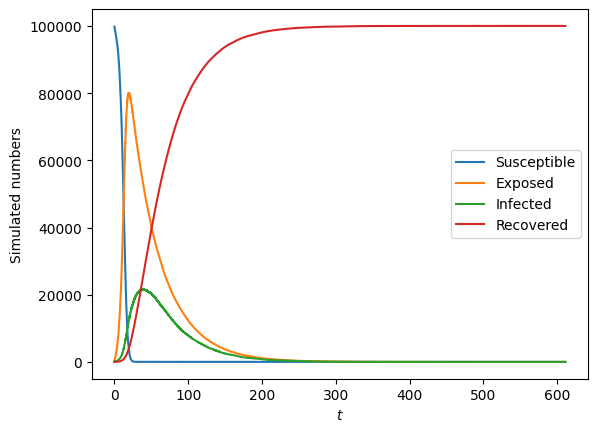

In [18]:
import EoN
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
import random


N = 100000
print("generating graph G with {} nodes".format(N))
G_1 = nx.fast_gnp_random_graph(N, 50./(N-1))


#We add random variation in the rate of leaving exposed class
#and in the partnership transmission rate.
#There is no variation in recovery rate.
node_attribute_dict = {node: 0.5 for node in G_1.nodes()}
edge_attribute_dict = {edge: 0.5 for edge in G_1.edges()}
nx.set_node_attributes(G_1, values=node_attribute_dict,
name="expose2infect_weight")
nx.set_edge_attributes(G_1, values=edge_attribute_dict,
name="transmission_weight")


#
#These individual and partnership attributes will be used to scale
#the transition rates. When we define \texttt{H} and \texttt{J}, we provide the name
#of these attributes.

#More advanced techniques to scale the transmission rates are shown in
#the online documentation
H = nx.DiGraph() #For the spontaneous transitions
H.add_node("S") #This line is actually unnecessary.
H.add_edge("E", "I", rate = 1/t_incubation, weight_label="expose2infect_weight")    #rate = alpha
H.add_edge("I", "R", rate = 0.05882)                                                #rate = gamma

J = nx.DiGraph() #for the induced transitions
J.add_edge(("I", "S"), ("I", "E"), rate = 5*0.05882, weight_label="transmission_weight") #rate = beta
IC = defaultdict(lambda: "S")
for node in range(200):
    IC[node] = "I"
    
    
return_statuses = ("S", "E", "I", "R")

print("doing Gillespie simulation")
t, S, E, I, R = EoN.Gillespie_simple_contagion(G_1, H, J, IC, return_statuses, tmax = float("Inf"))


print("done with simulation, now plotting")
plt.plot(t, S, label = "Susceptible")
plt.plot(t, E, label = "Exposed")
plt.plot(t, I, label = "Infected")
plt.plot(t, R, label = "Recovered")
plt.xlabel("$t$")
plt.ylabel("Simulated numbers")
plt.legend()
plt.show()


# More complicated network

### LFR_benchmark_graph

Generation Completed


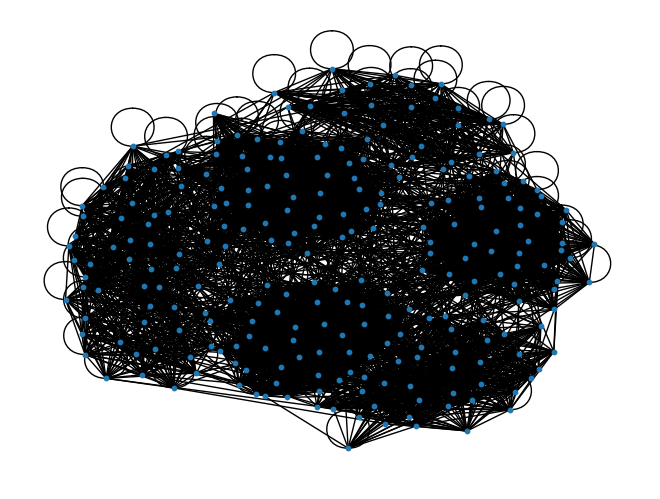

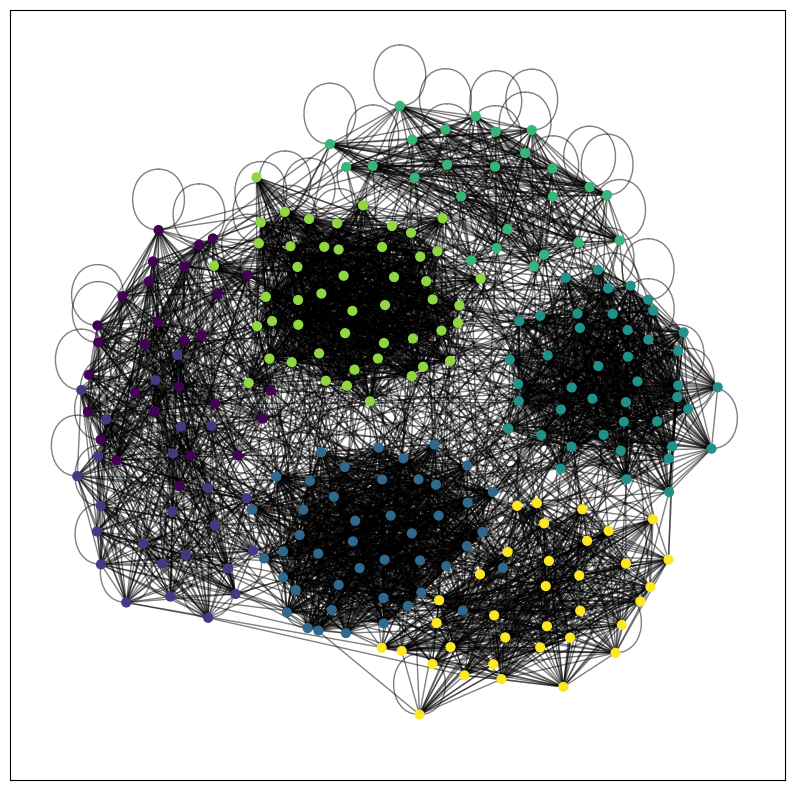

doing Gillespie simulation
done with simulation, now plotting


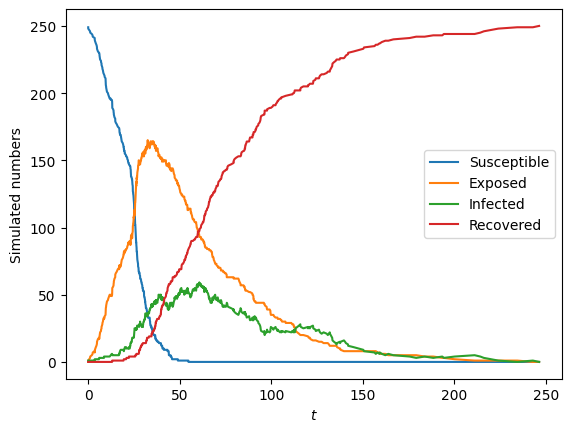

In [35]:
############################################### graph generation ###############################################
def genrate_lfr_graph(size=250):
    params = {"n":size, "tau1":1.1, "tau2":1.1, "mu":0.08, "min_degree":20, "max_degree":50}

    G = nx.LFR_benchmark_graph(params["n"], params["tau1"], params["tau2"], params["mu"], 
                        min_degree=params["min_degree"],
                        max_degree=params["max_degree"],
                        max_iters=5000, seed = 10,
                        )
    print("Generation Completed")
    return G  


sizes = [250, 500, 600, 700, 800, 900, 1000, 1200, 2000, 2500, 2800, 3000]
G = genrate_lfr_graph(size=250)
    
pos= nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=False, node_size=10, pos=pos)
plt.show()    
len(G.edges())


##################################### Community Detection ########################################

partition = community_louvain.best_partition(G)
f = plt.figure(figsize=(10, 10))
ax = f.add_subplot(1,1,1)

#pos = nx.circular_layout(G)
pos= nx.kamada_kawai_layout(G)
# color the nodes according to their partition
cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40, 
                       cmap=cmap, node_color=list(partition.values()),ax=ax)
nx.draw_networkx_edges(G, pos,alpha=0.5)
plt.show()


##################################### SIR modelization ########################################

G_1 = G
#We add random variation in the rate of leaving exposed class
#and in the partnership transmission rate.
#There is no variation in recovery rate.
node_attribute_dict = {node: 0.5 for node in G_1.nodes()}
edge_attribute_dict = {edge: 0.5 for edge in G_1.edges()}
nx.set_node_attributes(G_1, values=node_attribute_dict,
name="expose2infect_weight")
nx.set_edge_attributes(G_1, values=edge_attribute_dict,
name="transmission_weight")


#
#These individual and partnership attributes will be used to scale
#the transition rates. When we define \texttt{H} and \texttt{J}, we provide the name
#of these attributes.

#More advanced techniques to scale the transmission rates are shown in
#the online documentation
H = nx.DiGraph() #For the spontaneous transitions
H.add_node("S") #This line is actually unnecessary.
H.add_edge("E", "I", rate = 1/t_incubation, weight_label="expose2infect_weight")    #rate = alpha
H.add_edge("I", "R", rate = 0.05882)                                                #rate = gamma

J = nx.DiGraph() #for the induced transitions
J.add_edge(("I", "S"), ("I", "E"), rate = 5*0.05882, weight_label="transmission_weight") #rate = beta
IC = defaultdict(lambda: "S")
for node in range(1):
    IC[node] = "I"
    
    
return_statuses = ("S", "E", "I", "R")

print("doing Gillespie simulation")
t, S, E, I, R = EoN.Gillespie_simple_contagion(G_1, H, J, IC, return_statuses, tmax = float("Inf"))


print("done with simulation, now plotting")
plt.plot(t, S, label = "Susceptible")
plt.plot(t, E, label = "Exposed")
plt.plot(t, I, label = "Infected")
plt.plot(t, R, label = "Recovered")
plt.xlabel("$t$")
plt.ylabel("Simulated numbers")
plt.legend()
plt.show()

### random_cograph

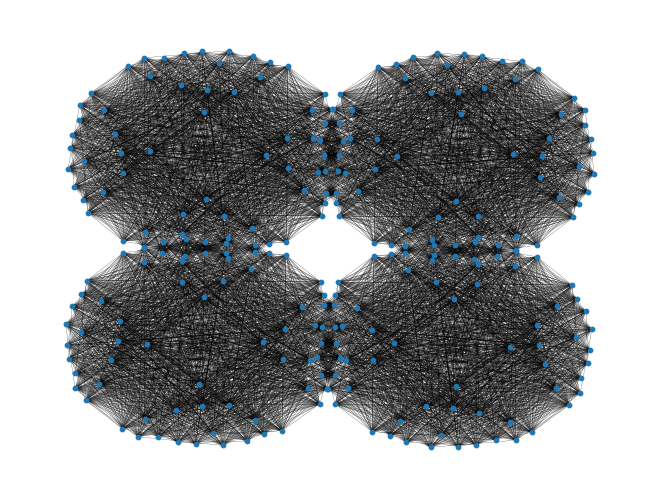

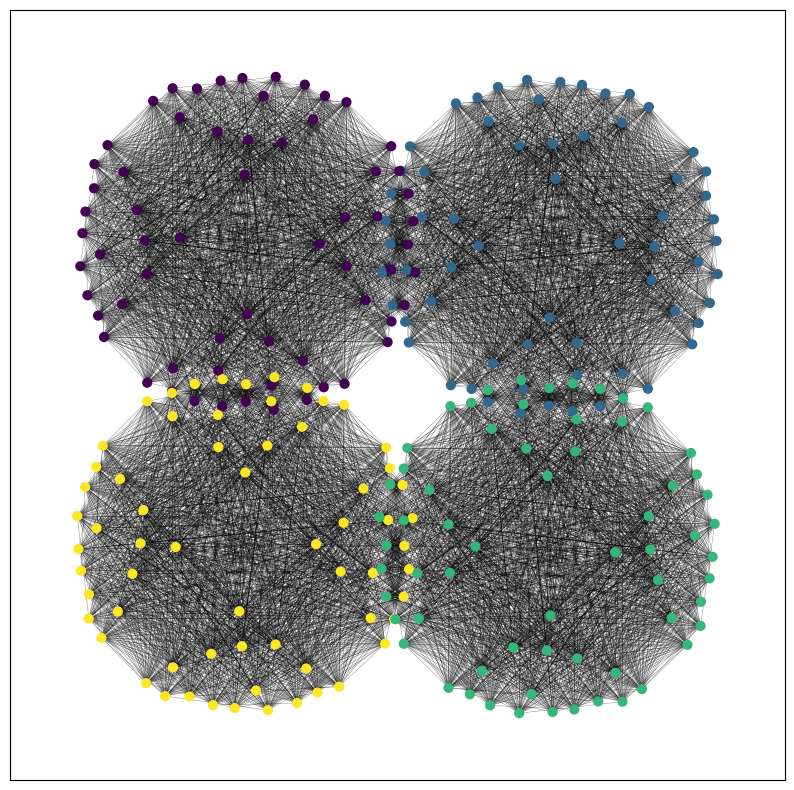

doing Gillespie simulation
done with simulation, now plotting


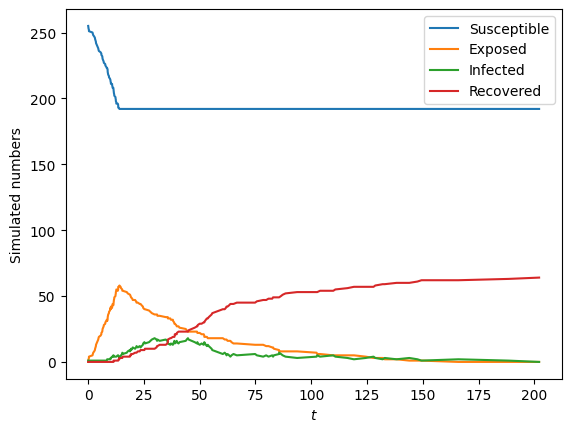

In [17]:
##################################### Graph création ########################################
G = nx.random_cograph(8, seed = 3)

pos= nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=False, node_size=10, pos=pos, width=0.15)
plt.show()    
len(G.edges())


##################################### Community Detection ########################################

partition = community_louvain.best_partition(G)
f = plt.figure(figsize=(10, 10))
ax = f.add_subplot(1,1,1)

#pos = nx.circular_layout(G)
pos= nx.kamada_kawai_layout(G)
# color the nodes according to their partition
cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40, 
                       cmap=cmap, node_color=list(partition.values()),ax=ax)
nx.draw_networkx_edges(G, pos,alpha=0.5, width=0.3)
plt.show()


##################################### SIR modelization ########################################

G_1 = G
#We add random variation in the rate of leaving exposed class
#and in the partnership transmission rate.
#There is no variation in recovery rate.
node_attribute_dict = {node: 0.5 for node in G_1.nodes()}
edge_attribute_dict = {edge: 0.5 for edge in G_1.edges()}
nx.set_node_attributes(G_1, values=node_attribute_dict,
name="expose2infect_weight")
nx.set_edge_attributes(G_1, values=edge_attribute_dict,
name="transmission_weight")


#
#These individual and partnership attributes will be used to scale
#the transition rates. When we define \texttt{H} and \texttt{J}, we provide the name
#of these attributes.

#More advanced techniques to scale the transmission rates are shown in
#the online documentation
H = nx.DiGraph() #For the spontaneous transitions
H.add_node("S") #This line is actually unnecessary.
H.add_edge("E", "I", rate = 1/t_incubation, weight_label="expose2infect_weight")    #rate = alpha
H.add_edge("I", "R", rate = 0.05882)                                                #rate = gamma

J = nx.DiGraph() #for the induced transitions
J.add_edge(("I", "S"), ("I", "E"), rate = 5*0.05882, weight_label="transmission_weight") #rate = beta
IC = defaultdict(lambda: "S")
for node in range(1):
    IC[node] = "I"
    
    
return_statuses = ("S", "E", "I", "R")

print("doing Gillespie simulation")
t, S, E, I, R = EoN.Gillespie_simple_contagion(G_1, H, J, IC, return_statuses, tmax = float("Inf"))


print("done with simulation, now plotting")
plt.plot(t, S, label = "Susceptible")
plt.plot(t, E, label = "Exposed")
plt.plot(t, I, label = "Infected")
plt.plot(t, R, label = "Recovered")
plt.xlabel("$t$")
plt.ylabel("Simulated numbers")
plt.legend()
plt.show()

# Cellular automate model

generating graph G
doing Gillespie simulation


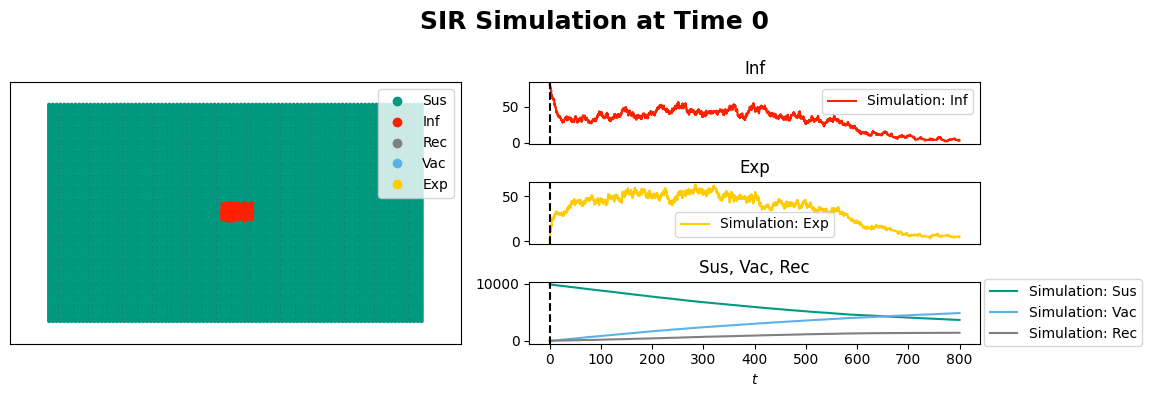

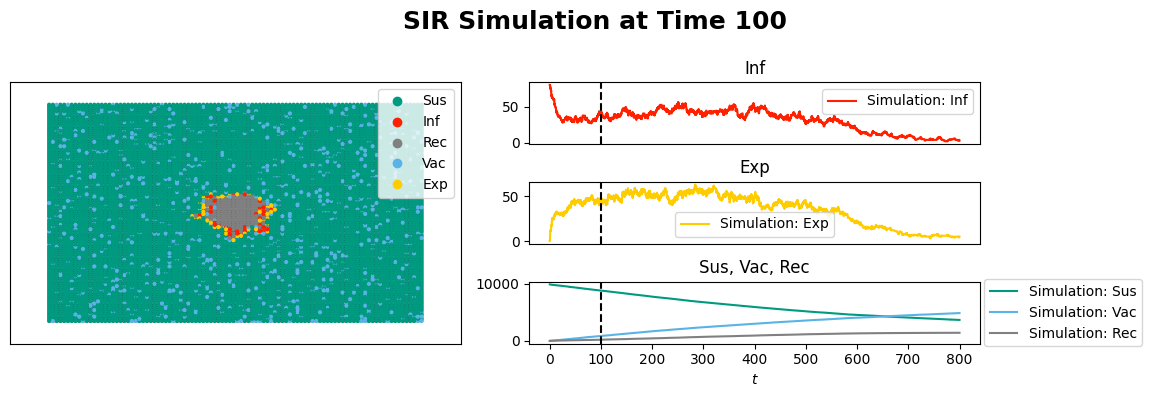

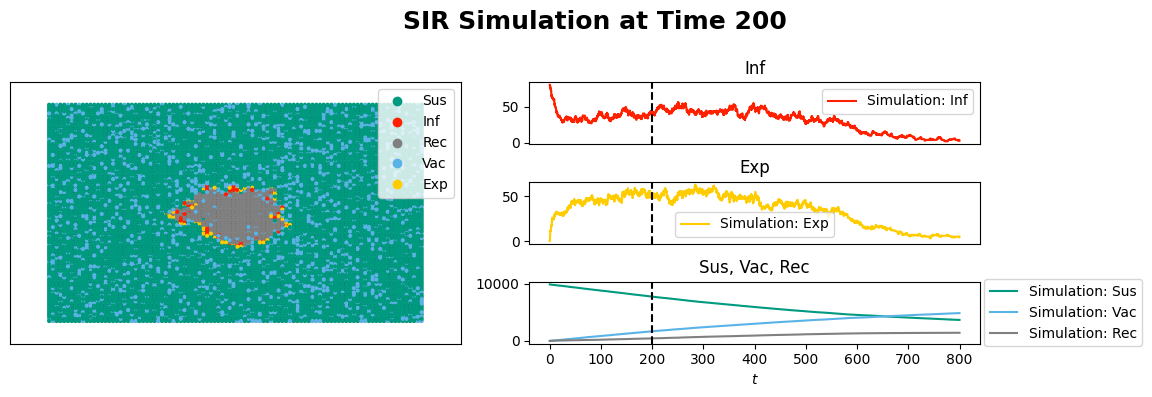

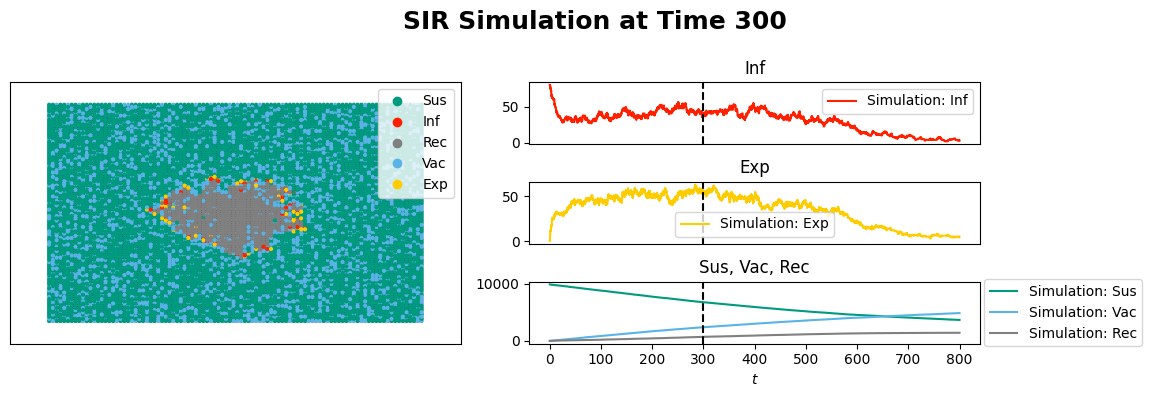

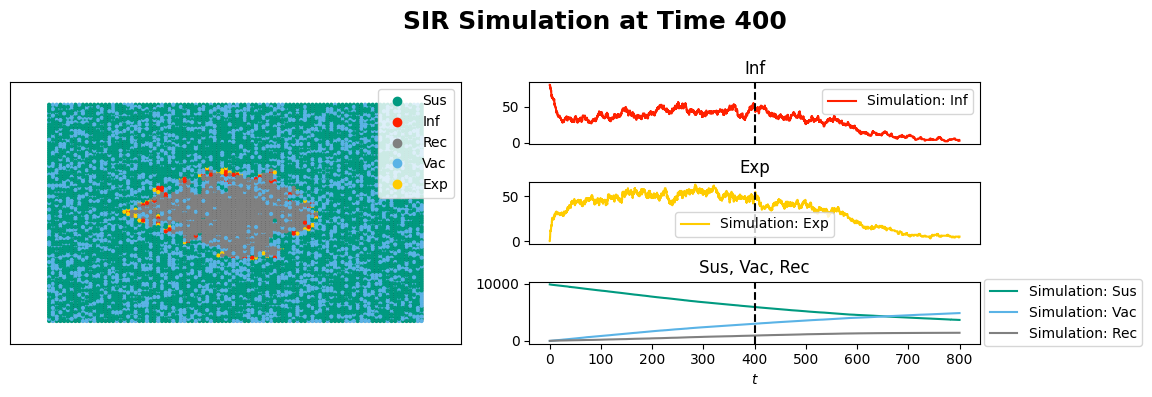

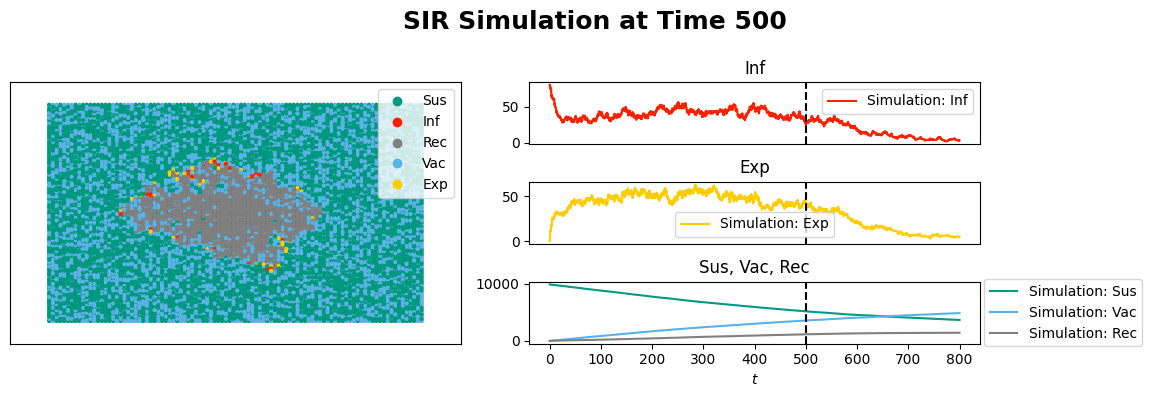

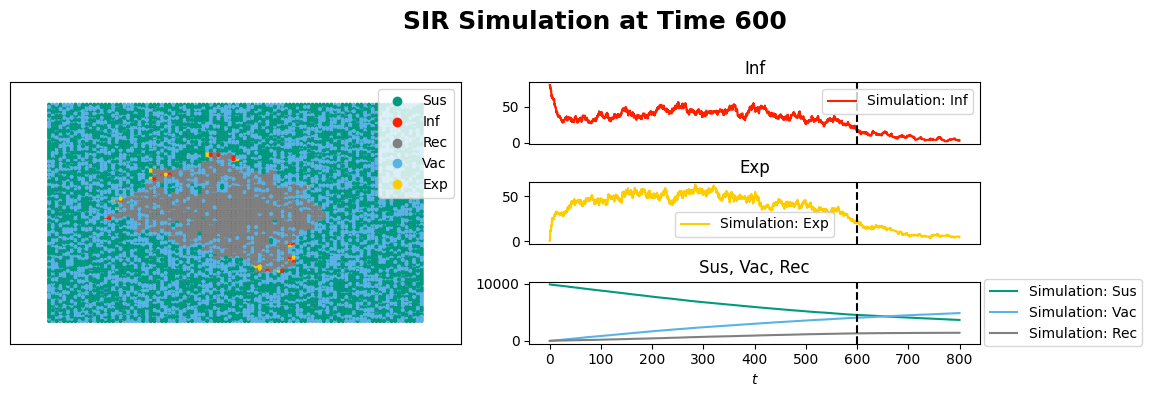

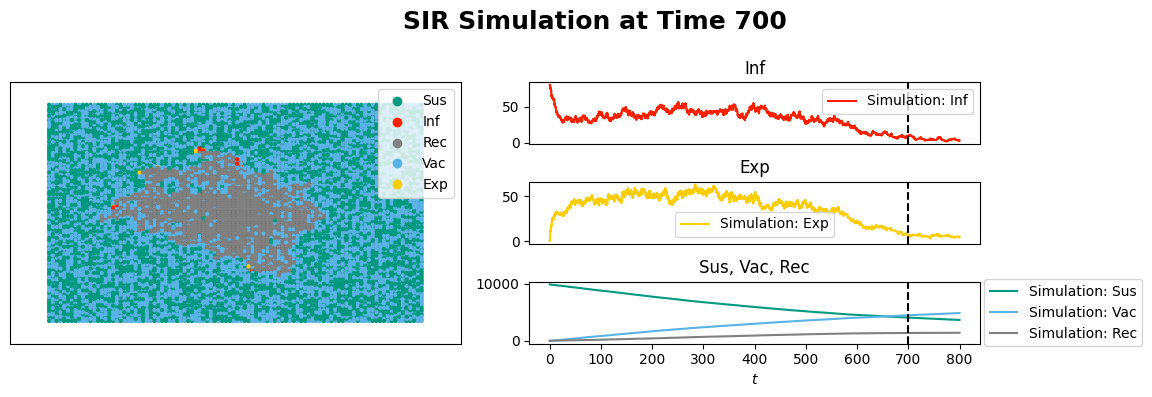

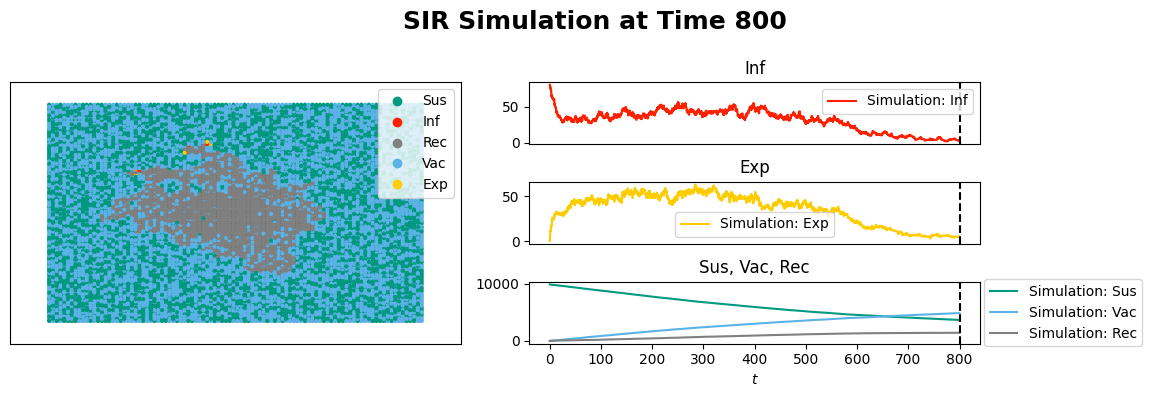

In [11]:
print("generating graph G")
G = nx.grid_2d_graph(100,100) #each node is (u,v) where 0<=u,v<=99
#we"ll initially infect those near the middle
initial_infections = [(u,v) for (u,v) in G if 45<u<55 and 45<v<55]

H = nx.DiGraph() #the spontaneous transitions
H.add_edge("Sus", "Vac", rate = 0.001)
H.add_edge("Exp", "Inf", rate = 1/t_incubation) #rate = alpha
H.add_edge("Inf", "Rec", rate = 0.05882)    #rate = gamma
J = nx.DiGraph() #the induced transitions
J.add_edge(("Inf", "Sus"), ("Inf", "Exp"), rate = 5*0.05882) #rate = beta

IC = defaultdict(lambda:"Sus") #a "dict", but by default the value is \texttt{"Sus"}.
for node in initial_infections:
    IC[node] = "Inf"
    
    
return_statuses = ["Sus", "Inf", "Rec", "Vac", "Exp"]

color_dict = {"Sus": "#009a80","Inf":"#ff2000", "Rec":"gray","Vac": "#5AB3E6", "Exp":"#ffcc00"}
pos = {node:node for node in G}
tex = False
sim_kwargs = {"color_dict":color_dict, "pos":pos, "tex":tex}
print("doing Gillespie simulation")
tmax = 800
sim = EoN.Gillespie_simple_contagion(G, H, J, IC, return_statuses, tmax=tmax,
return_full_data=True, sim_kwargs=sim_kwargs)
times, D = sim.summary()
#
#times is a numpy array of times. D is a dict, whose keys are the entries in
#return_statuses. The values are numpy arrays giving the number in that
#status at the corresponding time.
newD = {"Sus+Vac":D["Sus"]+D["Vac"], "Inf+Rec" : D["Inf"] + D["Rec"]}
#
#newD is a new dict giving number not yet infected or the number ever infected
#Let"s add this timeseries to the simulation.
#
new_timeseries = (times, newD)
sim.add_timeseries(new_timeseries, label = "Simulation",
color_dict={"Sus+Vac":"#E69A00", "Inf+Rec":"#CD9AB3"})
#ts_plots=[["Inf"], ["Exp"],["Sus" "Rec", "Vac"]]
ts_plots=[["Inf"], ["Exp"], ["Sus",  "Vac", "Rec"]]

for i in range(0,tmax+1, 100):
    sim.display(time=i, node_size = 4, ts_plots=ts_plots)
    plt.suptitle('SIR Simulation at Time {}'.format(i), fontweight='bold', fontsize=18, x=0.6)
    plt.subplots_adjust(top=0.8)
    plt.legend(bbox_to_anchor=(1.36, 0.5), loc='center right', borderaxespad=0.)
    #savefig in Images folder
    #plt.savefig('Images/SIR_{}.png'.format(i),  bbox_inches='tight')
    plt.show()
    


In [12]:
sim.__dict__


{'G': <networkx.classes.graph.Graph at 0x1bc49ff1e90>,
 '_node_history_': {(0, 0): ([0], ['Sus']),
  (0, 1): ([0, 109.9857581077221], ['Sus', 'Vac']),
  (0, 2): ([0], ['Sus']),
  (0, 3): ([0, 629.5602091606679], ['Sus', 'Vac']),
  (0, 4): ([0], ['Sus']),
  (0, 5): ([0], ['Sus']),
  (0, 6): ([0], ['Sus']),
  (0, 7): ([0], ['Sus']),
  (0, 8): ([0, 783.4595402663607], ['Sus', 'Vac']),
  (0, 9): ([0, 757.0762624909069], ['Sus', 'Vac']),
  (0, 10): ([0], ['Sus']),
  (0, 11): ([0, 288.2630437397093], ['Sus', 'Vac']),
  (0, 12): ([0, 558.4952635933594], ['Sus', 'Vac']),
  (0, 13): ([0], ['Sus']),
  (0, 14): ([0, 234.15300019667475], ['Sus', 'Vac']),
  (0, 15): ([0, 550.3046726851222], ['Sus', 'Vac']),
  (0, 16): ([0, 264.57391546899396], ['Sus', 'Vac']),
  (0, 17): ([0], ['Sus']),
  (0, 18): ([0], ['Sus']),
  (0, 19): ([0], ['Sus']),
  (0, 20): ([0, 121.47968554941944], ['Sus', 'Vac']),
  (0, 21): ([0], ['Sus']),
  (0, 22): ([0, 709.651632311642], ['Sus', 'Vac']),
  (0, 23): ([0], ['Sus']),
 